In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib torch torchvision

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y21vv34s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y21vv34s
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import torch
import os

In [3]:
# Cell 3: Download the SAM model checkpoint
# Note: Run this only once to download the checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth

--2025-04-11 10:52:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.118, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   339MB/s    in 7.1s    

2025-04-11 10:52:13 (345 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



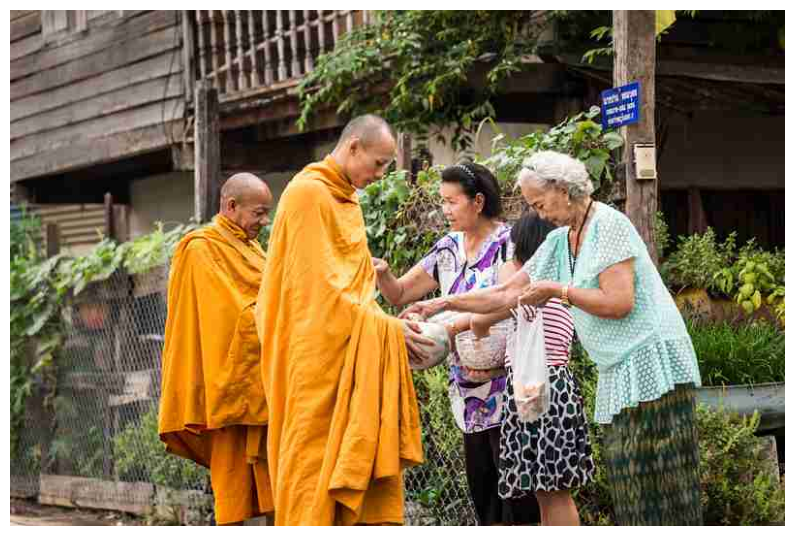

In [4]:
import urllib
import requests
import numpy as np

def load_image_from_url(image_url, readFlag=cv2.IMREAD_COLOR):
    try:
        # Send a GET request to fetch the image
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Convert the response content to a numpy array
        arr = np.asarray(bytearray(response.content), dtype=np.uint8)
        
        # Decode the image
        img = cv2.imdecode(arr, readFlag)
        if img is None:
            raise ValueError("Failed to decode image from URL")
        
        # Convert BGR to RGB for SAM
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    except (requests.RequestException, HTTPError, URLError) as e:
        print(f"Error fetching image from URL: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None
    
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Specify your image path
image_url = "https://webcoursesbangkok.com//wp-content/uploads/2021/06/monks.jpg" 
image = load_image_from_url(image_url)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
model_type = "vit_h"  # Using the largest model for best results
checkpoint_path = "sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)

# Set the image for the predictor
predictor.set_image(image)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [10]:
def get_bounding_boxes(masks, image_shape, confidence_threshold=0.01):
    objects = {}
    object_id = 1  # Start indexing objects from 1
    
    for mask in masks:
        mask_array = mask['segmentation']
        mask_uint8 = (mask_array * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > confidence_threshold * image_shape[0] * image_shape[1]:
                x, y, w, h = cv2.boundingRect(contour)
                # Store bounding box in the required format
                objects[str(object_id)] = {
                    "x": int(x),
                    "y": int(y),
                    "w": int(w),
                    "h": int(h)
                }
                object_id += 1
    
    # Create the final output dictionary
    result = {
        "width": int(image_shape[1]),  # image.shape[1] is width
        "height": int(image_shape[0]), # image.shape[0] is height
        "objects": objects
    }
    
    return result

import json
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

confidence_threshold = 0.01  # Adjustable threshold
bounding_box_data = get_bounding_boxes(masks, image.shape, confidence_threshold)

# Print the bounding box data
print(json.dumps(bounding_box_data, indent=4))

{
    "width": 800,
    "height": 533,
    "objects": {
        "1": {
            "x": 255,
            "y": 152,
            "w": 171,
            "h": 380
        },
        "2": {
            "x": 530,
            "y": 200,
            "w": 183,
            "h": 228
        },
        "3": {
            "x": 154,
            "y": 211,
            "w": 112,
            "h": 258
        },
        "4": {
            "x": 154,
            "y": 169,
            "w": 119,
            "h": 363
        },
        "5": {
            "x": 255,
            "y": 152,
            "w": 172,
            "h": 380
        },
        "6": {
            "x": 254,
            "y": 151,
            "w": 172,
            "h": 381
        },
        "7": {
            "x": 613,
            "y": 387,
            "w": 101,
            "h": 146
        },
        "8": {
            "x": 299,
            "y": 0,
            "w": 250,
            "h": 157
        },
        "9": {
            "x": 411,
     

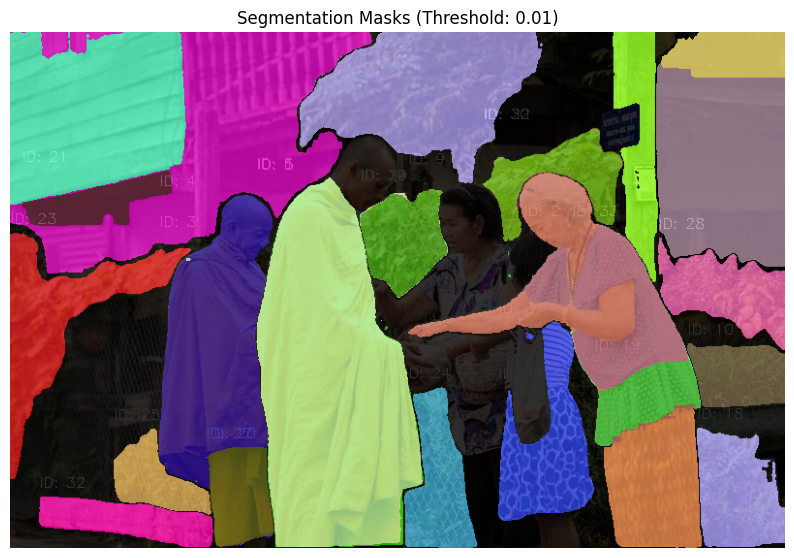

Number of objects detected: 34


In [11]:
import random

def draw_segmentation_masks(image, masks, bounding_box_data):
    image_copy = image.copy()
    overlay = np.zeros_like(image, dtype=np.uint8)
    
    # Sort masks by area (largest first) to avoid occlusion
    sorted_masks = sorted(masks, key=lambda m: -np.sum(m['segmentation']))
    
    for obj_id, bbox in bounding_box_data["objects"].items():
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        # Find the corresponding mask by matching bounding box
        for mask in sorted_masks:
            mask_array = mask['segmentation']
            mask_uint8 = (mask_array * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                mx, my, mw, mh = cv2.boundingRect(contour)
                if mx == x and my == y and mw == w and mh == h:
                    # Random color for visibility
                    color = (random.randint(0, 255), random.randint(0, 255), 
                           random.randint(0, 255))
                    # Apply color to the mask region
                    overlay[mask_array] = color
                    # Draw object ID
                    cv2.putText(image_copy, f"ID: {obj_id}", (x, y-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    break
    
    # Blend the overlay with the original image
    alpha = 0.8  # Increased opacity for more visible masks
    result_image = cv2.addWeighted(image_copy, 1.0 - alpha, overlay, alpha, 0.0)
    
    return result_image

result_image = draw_segmentation_masks(image, masks, bounding_box_data)

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title(f"Segmentation Masks (Threshold: {confidence_threshold})")
plt.show()

print(f"Number of objects detected: {len(bounding_box_data['objects'])}")

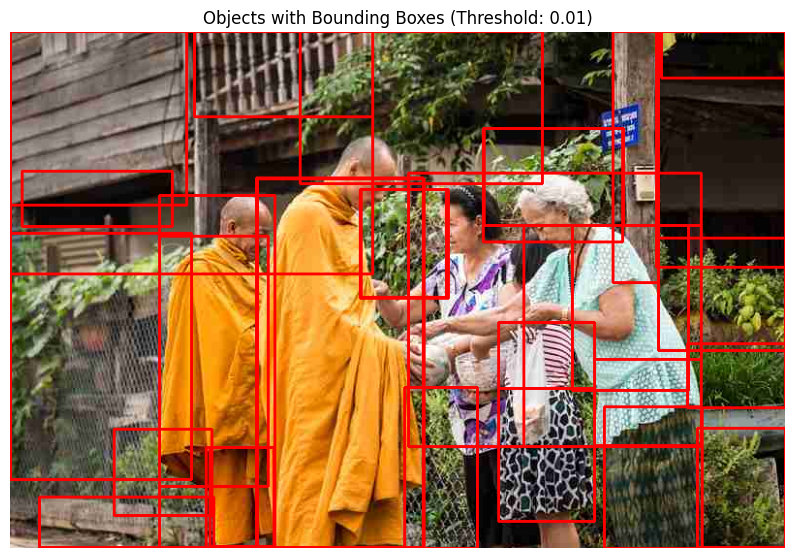

Number of objects detected: 34


In [12]:
def draw_bounding_boxes(image, bounding_box_data):
    image_copy = image.copy()
    for obj_id, bbox in bounding_box_data["objects"].items():
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        # Draw rectangle (top-left corner: (x, y), bottom-right corner: (x+w, y+h))
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
    return image_copy

result_image = draw_bounding_boxes(image, bounding_box_data)

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title(f"Objects with Bounding Boxes (Threshold: {confidence_threshold})")
plt.show()

print(f"Number of objects detected: {len(bounding_box_data['objects'])}")

In [9]:
output_path = "output_with_bboxes.jpg"
cv2.imwrite(output_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
print(f"Result saved to {output_path}")

# Save bounding box data as JSON
json_output_path = "bounding_boxes.json"
with open(json_output_path, 'w') as f:
    json.dump(bounding_box_data, f, indent=4)
print(f"Bounding box data saved to {json_output_path}")

Result saved to output_with_bboxes.jpg
Bounding box data saved to bounding_boxes.json
